# Data visualization

Notebook to visualize:
- the repartition of classes
- the 2D slices with the tumor mask
- the tumors

In [1]:
from google.colab import drive

drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd '/gdrive/My Drive/brain_tumor_dataset'

/gdrive/My Drive/brain_tumor_dataset


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [0]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

### Load images, masks and labels

In [5]:
labels = np.load('labels.npy')
images = np.load('images.npy')
masks = np.load('masks.npy')

print(labels.shape)
print(images.shape)
print(masks.shape)

(3064,)
(3064, 512, 512)
(3064, 512, 512)


#### Analyze the repartition of classes

number of meningioma (1): 708
number of glioma (2): 1426
number of pituitary tumor (3): 930


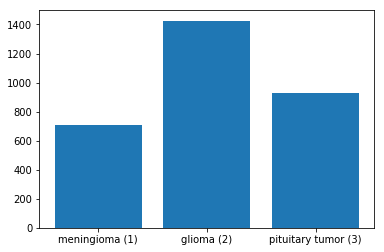

In [6]:
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts, 
        tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'])

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

#### Visualize some slices with their tumor mask

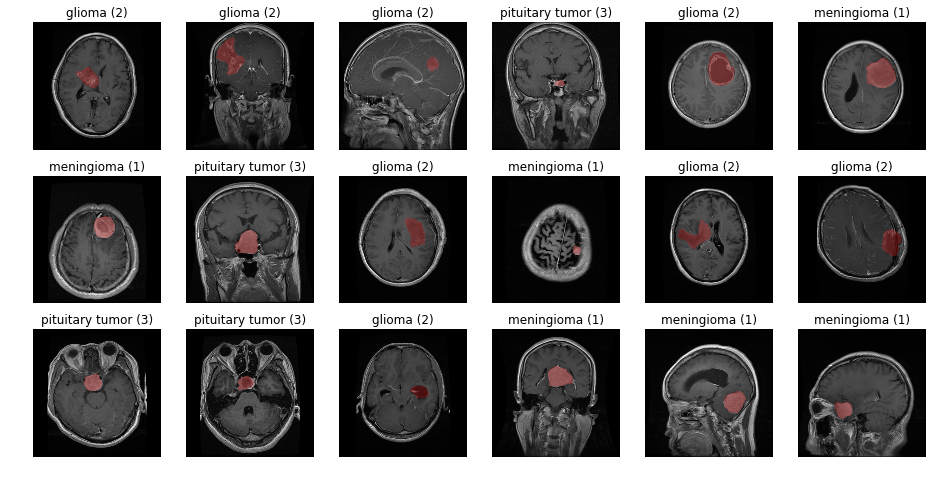

In [7]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images[idx], cmap='gray')
    
    # set black pixel as transparent for the mask
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.3, cmap='Set1')
    
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

### Crop the images on the tumors

In [0]:
def get_bounding_box(mask):
    """
    Return the bounding box of a mask image.
    """
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

    for row in range(mask.shape[0]):
        if mask[row, :].max() != 0:
            ymin = row
            break

    for row in range(mask.shape[0] - 1, -1, -1):
        if mask[row, :].max() != 0:
            ymax = row
            break

    for col in range(mask.shape[1]):
        if mask[:, col].max() != 0:
            xmin = col
            break

    for col in range(mask.shape[1] - 1, -1, -1):
        if mask[:, col].max() != 0:
            xmax = col
            break

    return xmin, ymin, xmax, ymax


def crop_to_bbox(image, bbox, crop_margin=10):
    """
    Crop an image to the bounding by forcing a squared image as output.
    """
    x1, y1, x2, y2 =  bbox
    
    # force a squared image
    max_width_height = np.maximum(y2 - y1, x2 - x1)
    y2 = y1 + max_width_height
    x2 = x1 + max_width_height

    # in case coordinates are out of image boundaries
    y1 = np.maximum(y1 - crop_margin, 0)
    y2 = np.minimum(y2 + crop_margin, image.shape[0])
    x1 = np.maximum(x1 - crop_margin, 0)
    x2 = np.minimum(x2 + crop_margin, image.shape[1])
    
    return image[y1:y2, x1:x2]


In [9]:
from IPython.display import display, clear_output

dim_cropped_image = 224

images_cropped = []

for i in range(images.shape[0]):
    if i % 10 == 0:
        # print the pourcentage of images processed
        clear_output(wait=True)
        display('[{}/{}] images processed: {:.1f} %'
                .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))
        
    bbox = get_bounding_box(masks[i])
    image = crop_to_bbox(images[i], bbox, 20)
    image = cv2.resize(image, dsize=(dim_cropped_image, dim_cropped_image),
                       interpolation=cv2.INTER_CUBIC)
    images_cropped.append(image)
    
clear_output(wait=True)
display('[{}/{}] images processed: {:.1f} %'
        .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

'[3064/3064] images processed: 100.0 %'

In [10]:
images_cropped = np.array(images_cropped)

print(images_cropped.shape)

(3064, 224, 224)


#### Visualize some tumors

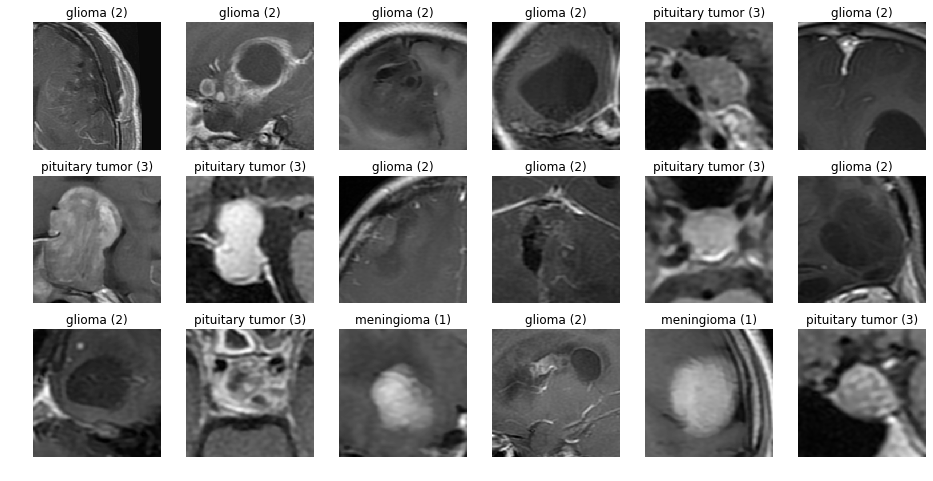

In [11]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images_cropped[idx], cmap='gray')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')